# Portfolio Optimization and Backtesting With Python

Written by Nathan Ramos, CFA${^®}$, of NR Capital Management, LLC.

Schedule a [FREE consultation](https://calendly.com/nrcapitalmanagement/30min) to see how we can enhance your investment strategy with statistical methods such as what you see below.

## Introduction

**Run this notebook by clicking "Runtime" in the top menu, then click "Run all", or press CTRL + F9.**

 Portfolio optimization is a quantitative process used to select an optimal set of assets from a larger pool to achieve specific investment objectives. The aim is to construct a portfolio that offers the maximum possible expected return for a given level of risk, or equivalently, to minimize risk for a given level of expected return. Traditional methods often rely on Markowitz’s Efficient Frontier, which models the trade-off between risk and return for a set of risky assets. The optimization problem involves input parameters like expected returns, variances, and covariances for the assets under consideration. Constraints may also be added to tailor the optimization to an investor's particular needs. By employing mathematical models and techniques, portfolio optimization helps investors make informed decisions, providing a data-driven foundation for selecting and allocating assets in an investment portfolio. However, these models should be used with caution and be used as a guideline rather than a definitive answer and is best employed in conjunction with other tools and analyses. No model is perfect and the true optimal portfolio may differ from the one computed by a portfolio optimization algorithm.

## Install Libraries

Before we dive into the code, we need to install the libraries that will be utilized throughout this notebook. Running the following cell will install the necessary Python packages:

In [1]:
# %%capture
# !pip install PyPortfolioOpt yahooquery bt ffn

- PyPortfolioOpt: For portfolio optimization algorithms and utility functions.
- yahooquery: To fetch financial data from Yahoo Finance.
- bt: For backtesting portfolio strategies.
- ffn: A financial function library for working with financial data.

Simply run the cell to install these packages. The %%capture magic command will suppress any output, ensuring a clean notebook.

## Import Libraries

Once the packages are installed, we need to import them to start using their features. Run the following cell to import the libraries:

In [2]:
import bt
import ffn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [3]:
from tqdm import tqdm
from yahooquery import Ticker
from cvxpy import SolverError
from pypfopt import risk_models as rm
from pypfopt import black_litterman, plotting, expected_returns, EfficientSemivariance
from pypfopt.exceptions import OptimizationError

Here's a brief overview of why we are using each library:

- bt: For backtesting and simulating portfolio strategies.
- ffn: Provides utility functions for financial data manipulation.
- pandas and numpy: Essential for data manipulation and numerical operations.
- matplotlib: For all data visualizations and plotting.
- tqdm: Provides progress bars for loops to indicate processing time.
- yahooquery: Fetches financial data from Yahoo Finance.
- pypfopt: Implements portfolio optimization algorithms, risk models, and utility functions.

By importing these libraries, we set up our Python environment for the various tasks in portfolio optimization.

## Define Inputs

In this section, we will define the key inputs required for our portfolio optimization algorithm. Portfolio optimization is highly dependent on the inputs provided, so it's crucial to understand the parameters you are setting. Below are the inputs we'll be working with:

### Portfolio Tickers

In [4]:
portfolio_tickers = [
    'SPY', # Stocks
    'BND', # Bonds
    'GLD', # Gold
    'GBTC' # Crypto
]

Here, we specify the assets that will be included in our portfolio optimization model. These tickers represent ETFs or other financial instruments for each asset class:

- **SPY**: Represents the S&P 500 index, covering a broad range of U.S. stocks.
- **BND**: A broad-based bond index.
- **GLD**: Tracks the price of Gold.
- **GBTC**: Represents a Bitcoin investment trust for cryptocurrency exposure.

### Weight Bounds

In [5]:
weight_bounds = [
    (0, 1.0), # SPY 0-100%
    (0, 1.0), # BND 0-100%
    (0, 0.1), # GLD 0-10%
    (0, 0.05) # GBTC 0-5%
]

For each asset specified, we set a range of allowable weights. These bounds serve as constraints during the optimization process:

- **SPY**: Allowable allocation between 0% and 100%.
- **BND**: Allowable allocation between 0% and 100%.
- **GLD**: Allowable allocation between 0% and 10%.
- **GBTC**: Allowable allocation between 0% and 5%.

These weight bounds can be adjusted based on your investment strategy and risk tolerance. They serve to enforce certain guidelines, like diversification or avoiding excessive concentration in risky assets.

### Benchmark Portfolio

In [6]:
benchmark_name = 'Market Cap Weighted Portfolio'
benchmark_portfolio = { # weights
    'SPY': 0.5458,
    'BND': 0.3771,
    'GLD': 0.0730,
    'GBTC': 0.0041
}

We also define a benchmark portfolio for comparison purposes. This could be a market-cap weighted portfolio or any other strategy you'd like to compare your optimized portfolio against.

In this example, we have a market cap weighted portfolio with the following asset allocations:

- **SPY**: 54.58%
- **BND**: 37.71%
- **GLD**: 7.30%
- **GBTC**: 0.41%

These weights serve as a point of reference to evaluate how well our optimized portfolio performs in comparison to a traditional market allocation.

In [7]:
# Set dates for historical prices
start_date = '2000-01-01'
end_date = '2023-09-01'

## Data Retrieval Functions

In this section, we define several Python functions that fetch and process the data needed for portfolio optimization. These functions leverage the yahooquery library to obtain financial data from Yahoo Finance. Here's an overview of each function:

In [8]:
def get_historical_prices(tickers, period='max', start_date=None, end_date=None):
    ticker_string = ' '.join(tickers)
    if start_date is None:
        data = Ticker(ticker_string).history(period='max')['adjclose'].reset_index()
    else:
        data = Ticker(ticker_string).history(start=start_date, end=end_date)['adjclose'].reset_index()
    df = data.pivot(index='date', columns='symbol', values='adjclose').dropna()
    try:
        df.index = df.index.to_series().dt.strftime('%Y-%m-%d')
    except AttributeError:
        pass
    df.index = pd.to_datetime(df.index)
    return df.sort_index(axis=1)

- Retrieves the historical adjusted closing prices for the given tickers.
- Allows specifying a period, start_date, and end_date.
- Returns a DataFrame with dates as indices and tickers as columns.

In [9]:
def get_summary_details(tickers):
    ticker_string = ' '.join(tickers)
    data_dict = Ticker(ticker_string).summary_detail
    summary_detail = pd.DataFrame.from_dict(data_dict, orient='index')
    return summary_detail.transpose().sort_index(axis=1)

- Fetches the summary details for the list of tickers.
- Returns a DataFrame containing various financial metrics like P/E ratio, market cap, etc.

In [10]:
def get_current_prices(tickers):
    ticker_string = ' '.join(tickers)
    data_dict = Ticker(ticker_string).price
    current_prices = pd.DataFrame.from_dict(data_dict, orient='index')
    current_prices = current_prices.transpose()
    return current_prices.sort_index(axis=1)

- Obtains the most recent prices for the list of tickers.
- Returns a DataFrame with the current prices.

In [11]:
def get_risk_free_rate(ticker='^TNX', method='current'):
    data_dict = Ticker(ticker).price
    risk_free_rate = pd.DataFrame.from_dict(data_dict, orient='index').transpose()
    risk_free_rate_name = risk_free_rate.loc['longName'].squeeze()
    risk_free_rate = round(risk_free_rate.loc['regularMarketPrice'].squeeze() / 100, 4)
    return risk_free_rate, risk_free_rate_name

- Obtains the current risk-free rate, typically represented by the 10-year U.S. Treasury note (^TNX).
- Returns rate and its associated name.

In [12]:
def get_historical_risk_free_rate(ticker='^TNX', period='max', start_date=None, end_date=None):
    if start_date is None:
        historical_risk_free_rate = get_historical_prices([ticker], period) / 100
    else:
        historical_risk_free_rate = get_historical_prices([ticker], start_date=start_date, end_date=end_date) / 100
        
    # Get the risk free rate name
    df = pd.DataFrame.from_dict(Ticker(ticker).price, orient='index').transpose()
    risk_free_rate_name = df.loc['longName'].squeeze()
    return historical_risk_free_rate, risk_free_rate_name

- Collects historical risk-free rates.
- Allows the option to specify a period, start_date, and end_date.

In [13]:
def process_historical_data(historical_prices, benchmark_prices, historical_risk_free_rate):
    price_tickers = list(historical_prices.columns)
    benchmark_tickers = list(benchmark_prices.columns)
    risk_free_ticker = list(historical_risk_free_rate.columns)
    historical_risk_free_rate = pd.concat([historical_prices, historical_risk_free_rate], axis=1).dropna()
    historical_risk_free_rate = historical_risk_free_rate[risk_free_ticker]
    historical_prices = pd.concat([historical_prices, historical_risk_free_rate], axis=1).dropna()
    historical_prices = historical_prices[price_tickers]
    benchmark_prices = pd.concat([benchmark_prices, historical_risk_free_rate], axis=1).dropna()
    benchmark_prices = benchmark_prices[benchmark_tickers]
    return historical_prices, benchmark_prices, historical_risk_free_rate

- Aligns historical prices and risk-free rates by date.
- Returns DataFrames that are aligned by date.

In [14]:
def process_weight_bounds(portfolio_tickers, weight_bounds):
    ticker_to_bounds = dict(zip(portfolio_tickers, weight_bounds))
    portfolio_tickers = sorted(portfolio_tickers)
    return [ticker_to_bounds[ticker] for ticker in portfolio_tickers]

- Maps weight bounds to their respective tickers in the portfolio.
- Returns a list of weights bounds sorted according to ticker names.

## Fetch Data

In this section, we use various helper functions to fetch financial data such as historical prices, summary details, and current prices. Here's what each function does:

- `get_historical_prices`: Fetches the historical adjusted closing prices for a given list of tickers.
- `get_summary_details`: Provides summary details for each stock, including market cap, PE ratio, and more.
- `get_current_prices`: Retrieves the current market prices of the listed tickers.
- `get_risk_free_rate`: Gets the risk-free rate, usually the yield on a 10-year Treasury note.
- `get_historical_risk_free_rate`: Retrieves the historical risk-free rate for backtesting purposes.
- `process_weight_bounds`: Processes the bounds for each ticker's weight in the portfolio.

In [15]:
historical_prices = get_historical_prices(portfolio_tickers)
benchmark_prices = get_historical_prices(benchmark_portfolio.keys())
summary_detail = get_summary_details(portfolio_tickers)
current_prices = get_current_prices(portfolio_tickers+list(benchmark_portfolio.keys()))
risk_free_rate, risk_free_rate_name = get_risk_free_rate()
historical_risk_free_rate, risk_free_rate_name = get_historical_risk_free_rate()
weight_bounds = process_weight_bounds(portfolio_tickers, weight_bounds)

In [16]:
names = current_prices.loc['shortName'].sort_index()
benchmark_portfolio = {key: value for key, value in sorted(benchmark_portfolio.items())}

## Extract and Display Data

After fetching the data, we proceed with data manipulation and visualization. Here, we:

1) Process the historical prices, benchmark prices, and historical risk-free rates to make sure they are synchronized in time.
2) Calculate and display the average historical returns for each asset in the portfolio.
3) Plot the rebased cumulative value of each asset.
4) Display the average risk-free rate.
5) Show the market capitalization for each asset in billions of dollars.
6) Plot the market weight for each asset in the portfolio.

By the end of this section, you'll have a comprehensive view of your portfolio's assets, which sets the stage for further analysis and optimization.

In [18]:
historical_prices, benchmark_prices, historical_risk_free_rate = process_historical_data(
    historical_prices, benchmark_prices, historical_risk_free_rate
)

In [19]:
average_historical_return = round(expected_returns.mean_historical_return(historical_prices), 4)
average_historical_return

symbol
BND     0.0095
GBTC    0.5276
GLD     0.0572
SPY     0.1161
dtype: float64

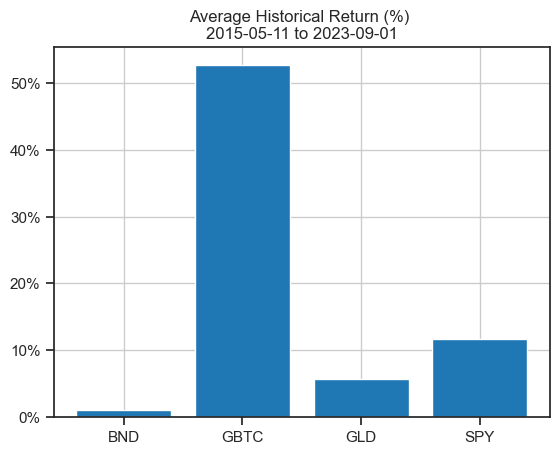

In [63]:
def format_with_percent(x, pos):
    return '{:,.0%}'.format(x)

fig, ax = plt.subplots()

ax.bar(list(average_historical_return.index), list(average_historical_return.values), color='tab:blue')
formatter = FuncFormatter(format_with_percent)
ax.yaxis.set_major_formatter(formatter)

plt.title('Average Historical Return (%) \n{} to {}'.format(
    historical_prices.index[0].strftime('%Y-%m-%d'),
    historical_prices.index[-1].strftime('%Y-%m-%d')
))

plt.grid()
plt.show();

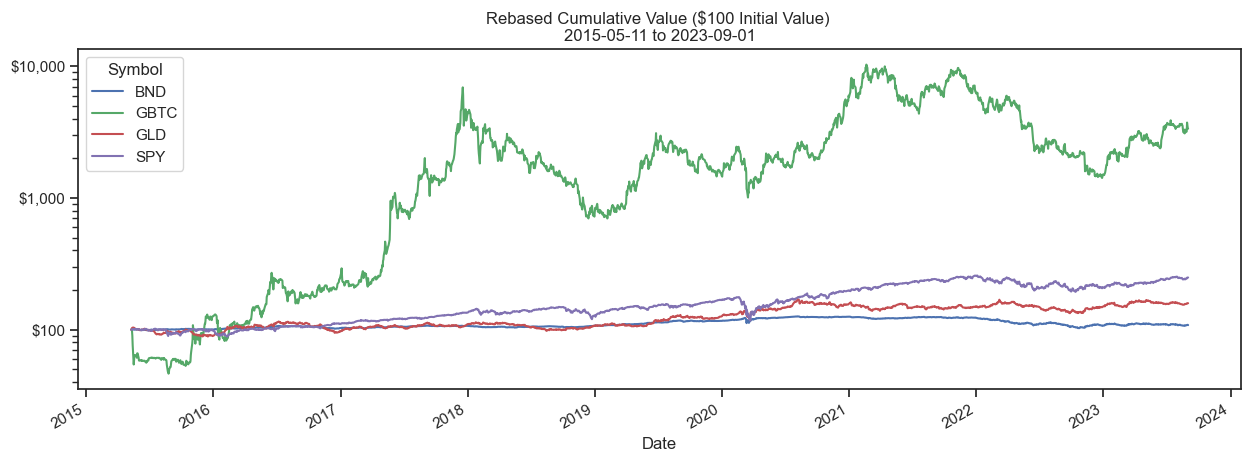

In [21]:
# Define custom formatting function
def format_with_commas(x, pos):
    return '${:,.0f}'.format(x)

# Create the plot
ax = ffn.core.rebase(historical_prices).plot(title='Rebased Cumulative Value ($100 Initial Value) \n{} to {}'.format(
    historical_prices.index[0].strftime('%Y-%m-%d'),
    historical_prices.index[-1].strftime('%Y-%m-%d')
), logy=True, figsize=(15, 5))

# Apply custom formatter
formatter = FuncFormatter(format_with_commas)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Date')
plt.legend(title='Symbol')

plt.show();

In [22]:
average_risk_free_rate = float(round(historical_risk_free_rate.mean().squeeze(), 4))
print('Average Risk-free Rate: {}%'.format(100 * average_risk_free_rate))

Average Risk-free Rate: 2.21%


In [23]:
market_caps = summary_detail.copy().loc['marketCap']
for ticker in market_caps.index:
    if market_caps[ticker] == {}:
        market_caps[ticker] = summary_detail.loc['totalAssets', ticker]
market_caps = (market_caps.astype('float64') / 1000000000).sort_index()
market_caps

BND     298.675929
GBTC      3.247860
GLD      57.822425
SPY     432.255173
Name: marketCap, dtype: float64

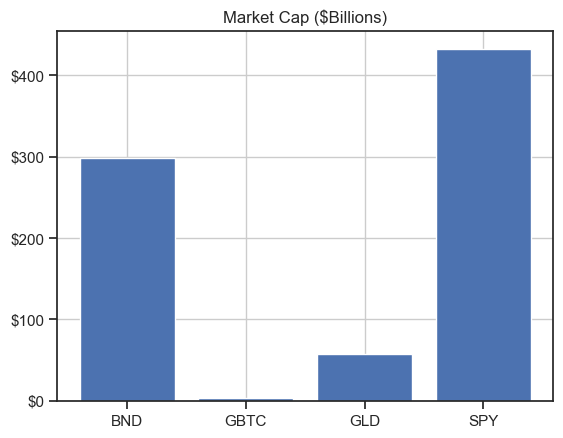

In [24]:
def format_with_commas(x, pos):
    return '${:,.0f}'.format(x)

fig, ax = plt.subplots()

ax.bar(list(market_caps.index), list(market_caps.values))
formatter = FuncFormatter(format_with_commas)
ax.yaxis.set_major_formatter(formatter)

plt.title('Market Cap ($Billions)')

plt.grid()
plt.show();

In [25]:
market_weights = (market_caps / market_caps.sum()).astype(float).round(4)
market_weights

BND     0.3771
GBTC    0.0041
GLD     0.0730
SPY     0.5458
Name: marketCap, dtype: float64

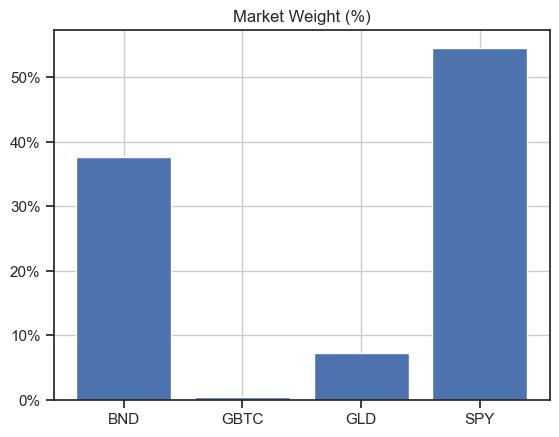

In [26]:
def format_with_percent(x, pos):
    return '{:,.0%}'.format(x)

fig, ax = plt.subplots()

ax.bar(list(market_weights.index), list(market_weights.values))
formatter = FuncFormatter(format_with_percent)
ax.yaxis.set_major_formatter(formatter)

plt.title('Market Weight (%)')

plt.grid()
plt.show();

In [27]:
market_prices = historical_prices / historical_prices.iloc[0] * 100
market_prices = (market_weights * market_prices).sum(axis=1)

In the next sections, we will delve deeper into portfolio optimization techniques, leveraging this extracted data.

## Risk Model

In this section, we focus on understanding the risks associated with the assets in our portfolio. To do so, we calculate the covariance matrix, which shows how different assets in the portfolio move in relation to each other. This is crucial for risk diversification and for selecting the best risk-adjusted portfolio.

Here are the key steps:

1) **Calculate Covariance Matrix**: We use the `risk_matrix` function from the risk model library (`rm`) to calculate the covariance matrix of historical prices.
  
2) **Fix Non-Positive Semidefinite Matrix**: Covariance matrices should be positive semidefinite. However, due to numerical issues or other complexities, this might not always be the case. We use `fix_nonpositive_semidefinite` to adjust the matrix as needed.

3) **Visualize Correlation Matrix**: Finally, we visualize the correlation matrix which is a normalized version of the covariance matrix. This helps in understanding how different assets are related to each other.

The "oracle approximating" method is employed for estimating the covariance matrix. This method aims to provide an optimal estimate of the true covariance matrix by employing a shrinkage-like technique. By adjusting the original sample covariance matrix towards a target, the "oracle approximating" method improves the matrix's condition and stability, which are essential for further financial analyses.

In [28]:
# Calculate the covariance matrix using oracle approximating method
covariance_matrix = rm.risk_matrix(historical_prices, method='oracle_approximating')

# Fix non-positive semidefinite issues if any
covariance_matrix = rm.fix_nonpositive_semidefinite(covariance_matrix)

# Display the covariance matrix
covariance_matrix

symbol,BND,GBTC,GLD,SPY
symbol,,,,
BND,0.003228,0.003435,0.002807,0.001019
GBTC,0.003435,0.809014,0.013232,0.038098
GLD,0.002807,0.013232,0.019835,0.000833
SPY,0.001019,0.038098,0.000833,0.034406


Correlation Matrix Plot


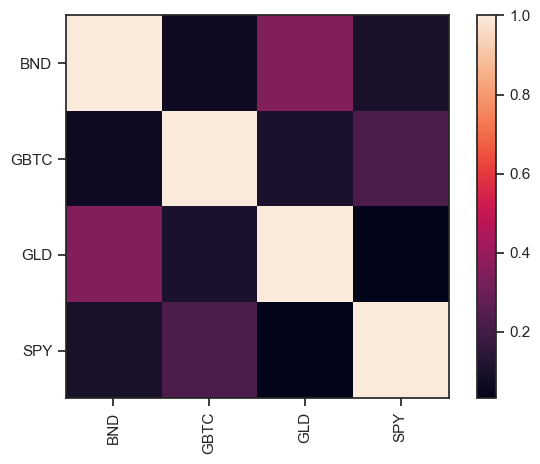

In [29]:
print('Correlation Matrix Plot')
plotting.plot_covariance(covariance_matrix, plot_correlation=True, show_tickers=True);

By analyzing the correlation matrix, we can get an idea of which assets have similar behavior and which ones offer good diversification opportunities. The closer the correlation value is to 1, the more similar the assets behave. On the other hand, a correlation close to -1 indicates a strong negative relationship, offering diversification benefits.

## Market-Implied Expected Return

In this section, we compute the market-implied expected returns based on the market risk aversion, covariance matrix, risk free rate and market capitalizations. These expected returns serve as the prior beliefs in the Black-Litterman model. We also visualize these returns for a clearer understanding of what the market implies about the future.

Key steps include:

1. **Calculate Market-Implied Risk Aversion (Delta)**: This parameter quantifies the market's tolerance for risk and is a crucial input for the Black-Litterman model.

2. **Compute Market-Implied Prior Returns**: Using market capitalizations, delta, and the covariance matrix, we calculate these returns.

3. **Visualization**: A bar chart presents these market-implied expected returns.

In [30]:
delta = black_litterman.market_implied_risk_aversion(market_prices)
market_implied_expected_returns = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix, risk_free_rate).astype(float).round(4)
market_implied_expected_returns

symbol
BND     0.0490
GBTC    0.1377
GLD     0.0527
SPY     0.1123
dtype: float64

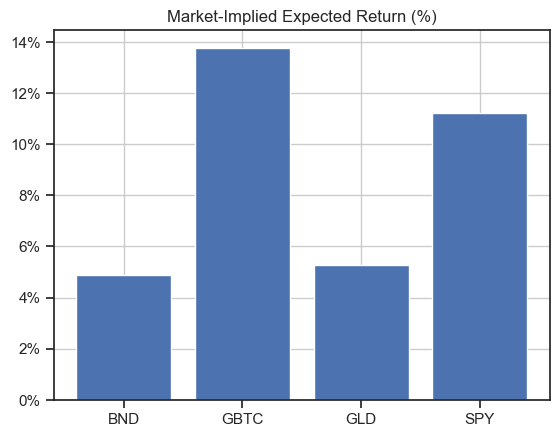

In [31]:
def format_with_commas(x, pos):
    return '{:,.0%}'.format(x)

fig, ax = plt.subplots()

ax.bar(list(market_implied_expected_returns.index), list(market_implied_expected_returns.values))
formatter = FuncFormatter(format_with_commas)
ax.yaxis.set_major_formatter(formatter)

plt.title('Market-Implied Expected Return (%)')

plt.grid()
plt.show();

## Posterior Expected Return

In this section, we incorporate the investor's views into our model to generate the posterior expected returns. This gives us an adjusted set of expected returns, combining market expectations and our own views.

Key steps are as follows:

1) Investor Views and Confidences: These are the rates of return we expect for certain assets and how confident we are in these views.

2) Black-Litterman Model: We use this model to combine our views and the market-implied prior to arrive at a new set of expected returns.

3) Clip the Returns: The Black-Litterman model can sometimes generate extreme values, which we clip to a range defined by the minimum and maximum between our views and the market-implied expected returns.

4) Visualization: A bar chart presents these posterior expected returns.

In [32]:
investor_views = {
    'SPY': 0.0044,
    'BND': 0.0500
}

In [33]:
view_confidences = pd.Series({
    'SPY': 0.4415,
    'BND': 0.5000
})

In [34]:
bl = black_litterman.BlackLittermanModel(
    covariance_matrix,
    pi='market',
    absolute_views=investor_views,
    risk_aversion=delta,
    market_caps=market_caps.loc[portfolio_tickers],
    risk_free_rate=risk_free_rate,
    omega='idzorek',
    view_confidences=list(view_confidences)
)

In [35]:
posterior_covariance_matrix = bl.bl_cov()
posterior_expected_returns = bl.bl_returns()

In [36]:
investor_views = pd.Series(investor_views)
min_values = pd.concat([market_implied_expected_returns, investor_views], axis=1).min(axis=1)
max_values = pd.concat([market_implied_expected_returns, investor_views], axis=1).max(axis=1)
posterior_expected_returns = round(posterior_expected_returns.clip(lower=min_values, upper=max_values), 4)
posterior_expected_returns

symbol
BND     0.0490
GBTC    0.1377
GLD     0.0527
SPY     0.0649
dtype: float64

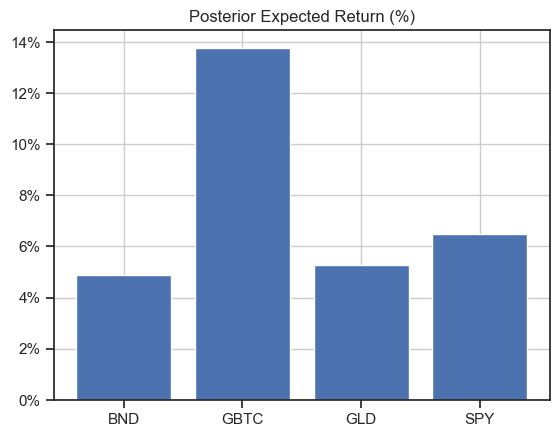

In [37]:
def format_with_percent(x, pos):
    return '{:,.0%}'.format(x)

fig, ax = plt.subplots()

ax.bar(list(posterior_expected_returns.index), list(posterior_expected_returns.values))
formatter = FuncFormatter(format_with_percent)
ax.yaxis.set_major_formatter(formatter)

plt.title('Posterior Expected Return (%)')

plt.grid()
plt.show();

By the end of this section, you will have a nuanced understanding of the expected returns, combining both market expectations and your own views. This will serve as a cornerstone for the portfolio optimization process that follows.

## Compute Efficient Frontier

In this section, we compute the Efficient Frontier using Efficient Semivariance. This involves optimizing the portfolio for varying levels of risk to find the portfolio that offers the maximum expected return for a given level of risk. Additionally, we identify the optimal portfolio, which is the one that maximizes the Sortino Ratio.

The key steps are as follows:

1) **Initialize DataFrames**: Create DataFrames to store portfolio performances (`performance_df_optimal`) and weights (`weights_df_optimal`).

2) **Find Minimum Risk Portfolio**: Attempt to find the portfolio with the lowest possible risk, which serves as our starting point.

3) **First Optimization Loop**: Perform a loop to find the highest possible risk (`max_risk`) for the Efficient Frontier.

4) **Second Optimization Loop**: Run the portfolio optimization for different risk levels between the minimum and maximum risk to build the Efficient Frontier.

5) **Identify Optimal Portfolio**: Out of all portfolios on the Efficient Frontier, identify the one with the highest Sortino Ratio as the optimal portfolio.

6) **Visualize the Efficient Frontier**: Plot the portfolios on the Efficient Frontier along with the Capital Market Line.

In [38]:
# Initialize dataframes to store portfolio performances and weights
performance_df_optimal = pd.DataFrame(columns=['Expected annual return', 'Annual semi-deviation', 'Sortino ratio'])
weights_df_optimal = pd.DataFrame()

# Find the minimum risk portfolio
try:
    es = EfficientSemivariance(posterior_expected_returns, expected_returns.returns_from_prices(historical_prices), weight_bounds=weight_bounds)
    es.min_semivariance()
    min_risk_performance = es.portfolio_performance(risk_free_rate=risk_free_rate)
    min_risk = min_risk_performance[1]
    
    # Store the min_risk_performance and weights as the first entry
    performance_df_optimal.loc[1] = min_risk_performance
    min_risk_weights = pd.DataFrame(list(es.clean_weights().items()), columns=['symbol', 'weight']).set_index('symbol')
    min_risk_weights.columns = [1]
    weights_df_optimal = min_risk_weights
    
except OptimizationError:
    print("Failed to find minimum risk portfolio.")
    min_risk = 0.0025

# Run the first optimization loop to find max_risk
successful_runs = 1  # Start at 1 because we've already added the minimum risk portfolio
max_risk = 0  # Initialize max_risk to zero

for i, target_risk in tqdm(enumerate(np.linspace(min_risk + 0.0005, 1.0, 10))):
    while True:  # Infinite loop to keep retrying with incremented target_risk
        try:
            historical_returns = expected_returns.returns_from_prices(historical_prices)
            es = EfficientSemivariance(posterior_expected_returns, historical_returns, weight_bounds=weight_bounds)
            es.efficient_risk(target_risk)
            performance = es.portfolio_performance(risk_free_rate=risk_free_rate)
            
            # Update max_risk if this portfolio has higher risk
            max_risk = max(max_risk, performance[1])

            # If no error, break the infinite loop
            break

        except SolverError:  # Catch the specific SolverError
            target_risk += 0.0005  # increment target_risk by 0.0005
            continue  # continue the while loop

        except OptimizationError:  # Catch the specific OptimizationError
            break  # break the infinite loop and continue with the next 'target_risk' value

# Now max_risk contains the maximum semi-deviation observed
risk_range = np.linspace(min_risk + 0.0005, max_risk, 99)  # Use 99 because the first portfolio is already there

for i, target_risk in tqdm(enumerate(risk_range)):
    if successful_runs >= 100:  # Stop if 100 successful portfolios are generated
        break

    while True:  # Infinite loop to keep retrying with incremented target_risk
        try:
            # Run the optimization
            historical_returns = expected_returns.returns_from_prices(historical_prices)
            es = EfficientSemivariance(posterior_expected_returns, historical_returns, weight_bounds=weight_bounds)
            es.efficient_risk(target_risk)
            weights = es.clean_weights()

            # Store the performance
            performance = es.portfolio_performance(risk_free_rate=risk_free_rate)
            performance_df_optimal.loc[successful_runs + 1] = performance

            # Convert weights to dataframe and store
            temp_weights_df = pd.DataFrame(list(weights.items()), columns=['symbol', 'weight']).set_index('symbol')
            temp_weights_df.columns = [successful_runs + 1]
            weights_df_optimal = pd.concat([weights_df_optimal, temp_weights_df], axis=1)

            successful_runs += 1

            # If no error, break the infinite loop
            break

        except SolverError:  # Catch the specific SolverError
            target_risk += 0.0005  # increment target_risk by 0.0005
            continue  # continue the while loop

        except OptimizationError:  # Catch the specific OptimizationError
            break  # break the infinite loop and continue with the next 'target_risk' value

performance_df_optimal = round(performance_df_optimal.T, 4)
weights_df_optimal = round(weights_df_optimal, 4)

0it [00:00, ?it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
1it [00:00,  2.75it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
10it [00:04,  2.43it/s]
0it [00:00, ?it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
99it [00:12,  8.14it/s]


In [39]:
# Find the portfolio with the maximum Sortino Ratio
optimal_portfolio_index = performance_df_optimal.loc['Sortino ratio'].idxmax() + 1  # +1 because portfolio index starts at 1

# Extracting the details of the optimal portfolio
optimal_portfolio_details = round(performance_df_optimal.iloc[:, optimal_portfolio_index - 1], 4)  # -1 because DataFrame index starts at 0

print(f"The optimal portfolio is Portfolio {optimal_portfolio_index} with the following details:")
print(optimal_portfolio_details)
print("\n")
print(f"The optimal weights in Portfolio {optimal_portfolio_index}: ")
print(weights_df_optimal[optimal_portfolio_index])

The optimal portfolio is Portfolio 15 with the following details:
Expected annual return    0.0557
Annual semi-deviation     0.0525
Sortino ratio             0.2662
Name: 15, dtype: float64


The optimal weights in Portfolio 15: 
symbol
BND     0.6826
GBTC    0.0380
GLD     0.0942
SPY     0.1852
Name: 15, dtype: float64


In [40]:
performance_df_optimal

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Expected annual return,0.0500,0.0512,0.0515,0.0520,0.0525,0.0529,0.0533,0.0536,0.0539,0.0543,...,0.0677,0.0678,0.0679,0.0680,0.0681,0.0682,0.0683,0.0684,0.0684,0.0685
Annual semi-deviation,0.0390,0.0400,0.0405,0.0415,0.0425,0.0435,0.0445,0.0455,0.0465,0.0475,...,0.1283,0.1293,0.1303,0.1313,0.1323,0.1333,0.1343,0.1353,0.1363,0.1372
Sortino ratio,0.2123,0.2373,0.2417,0.2489,0.2539,0.2575,0.2601,0.2621,0.2635,0.2645,...,0.2024,0.2016,0.2008,0.2000,0.1993,0.1985,0.1978,0.1970,0.1963,0.1956


In [41]:
pd.concat([names, weights_df_optimal], axis=1)

,shortName,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
BND,Vanguard Total Bond Market ETF,0.9239,0.8518,0.8403,0.8192,0.8011,0.7853,0.7715,0.7582,0.7460,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.00
GBTC,GRAYSCALE BITCOIN TRUST BTC,0.0000,0.0053,0.0073,0.0112,0.0146,0.0176,0.0204,0.0230,0.0254,...,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.050,0.0500,0.05
GLD,SPDR Gold Trust,0.0197,0.0442,0.0482,0.0551,0.0608,0.0657,0.0698,0.0736,0.0771,...,0.0721,0.0638,0.0558,0.0474,0.0394,0.0312,0.0232,0.015,0.0075,0.00
SPY,SPDR S&P 500,0.0564,0.0987,0.1042,0.1145,0.1234,0.1314,0.1383,0.1452,0.1515,...,0.8779,0.8862,0.8942,0.9026,0.9106,0.9188,0.9268,0.935,0.9425,0.95


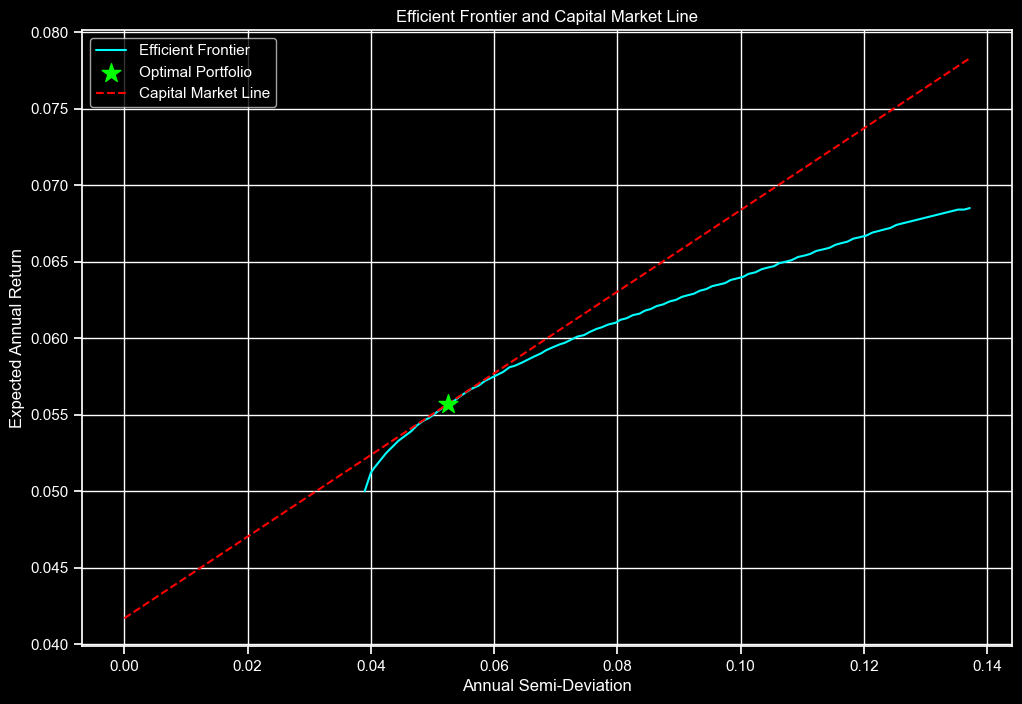

In [42]:
with plt.style.context('dark_background'):
    # Plotting
    plt.figure(figsize=(12, 8))

    # Find the optimal portfolio
    optimal_portfolio = performance_df_optimal[optimal_portfolio_index]

    # Plot the efficient frontier
    plt.plot(performance_df_optimal.loc['Annual semi-deviation'], performance_df_optimal.loc['Expected annual return'], c='cyan', label='Efficient Frontier', zorder=1)
    plt.xlabel('Annual Semi-Deviation')
    plt.ylabel('Expected Annual Return')
    plt.title('Efficient Frontier and Capital Market Line')

    # Plot the optimal portfolio
    plt.scatter(optimal_portfolio['Annual semi-deviation'], optimal_portfolio['Expected annual return'], c='lime', marker='*', label='Optimal Portfolio', zorder=3, s=200)

    # Plot the Capital Market Line
    x_range = np.linspace(0, max(performance_df_optimal.loc['Annual semi-deviation']), 100)
    y_cml = risk_free_rate + ((optimal_portfolio['Expected annual return'] - risk_free_rate) / optimal_portfolio['Annual semi-deviation']) * (x_range)
    plt.plot(x_range, y_cml, color='red', linestyle='--', label='Capital Market Line', zorder=2)

    plt.legend()
    plt.grid()
    plt.show();

By the end of this section, we will have a clear understanding of the range of risk-return trade-offs available to us, which is crucial for making informed investment decisions.

## Monte Carlo Simulation

Monte Carlo Simulation offers a stochastic approach to portfolio optimization. Unlike deterministic methods like Efficient Frontier, Monte Carlo simulation generates a multitude of random portfolios. This approach provides a more comprehensive view of the portfolio possibilities within the defined constraints.

### Key Steps

1. **Define Random Weight Function**: Create a function, `random_weights_with_bounds`, to generate portfolio weights within given bounds.

2. **Initialize DataFrames**: Create DataFrames (`performance_df_mc` and `weights_df_mc`) to store the performance metrics and weights of each randomly generated portfolio.

3. **Generate Random Portfolios**: Loop through `n_portfolios` number of times to create portfolios with random weights, while adhering to the weight bounds.

4. **Calculate Portfolio Performance**: For each generated portfolio, use Efficient Semivariance to compute performance metrics such as Expected Annual Return, Annual Semi-Deviation, and Sortino Ratio.

5. **Identify Optimal Portfolio**: Among the randomly generated portfolios, identify the one that maximizes the Sortino Ratio.

6. **Visualization**: Create a scatter plot that displays the random portfolios along with the Efficient Frontier and Capital Market Line.

In [43]:
def random_weights_with_bounds(n, weight_bounds):
    lower_bounds, upper_bounds = zip(*weight_bounds)
    lower_bounds = np.array(lower_bounds)
    upper_bounds = np.array(upper_bounds)

    weights = np.zeros(n)
    remaining = 1.0  # Start with a sum of 1 to allocate

    for i in range(n - 1):  # Loop until the second last element
        low = max(lower_bounds[i], 0)  # Lower bound for this asset
        high = min(upper_bounds[i], remaining - np.sum(lower_bounds[i + 1:]))  # Upper bound while ensuring future lower bounds can be met

        if high > low:
            w = np.random.uniform(low, high)
        else:
            w = low  # high and low can be the same when tight bounds exist

        weights[i] = w
        remaining -= w

    weights[-1] = remaining  # Last weight takes the remaining sum to make it 1

    return weights

# Initialize dataframes to store portfolio performances and weights
performance_df_mc = pd.DataFrame(columns=['Expected annual return', 'Annual semi-deviation', 'Sortino ratio'])
weights_df_mc = pd.DataFrame()
n_portfolios = 10000  # Number of random portfolios to generate

# Loop through and generate portfolios
for i in tqdm(range(n_portfolios)):
    try:
        # Generate random weights that obey the weight_bounds
        random_weights = random_weights_with_bounds(len(historical_prices.columns), weight_bounds)
        
        # Convert random_weights to dictionary
        random_weights_dict = dict(zip(historical_prices.columns, random_weights))
        
        es = EfficientSemivariance(posterior_expected_returns, expected_returns.returns_from_prices(historical_prices))
        es.set_weights(random_weights_dict)  # Set the weights here
        performance = es.portfolio_performance(risk_free_rate=risk_free_rate)
        
        # Store the performance
        performance_df_mc.loc[i] = performance
        
        # Convert weights to dataframe and store
        temp_weights_df = pd.DataFrame(random_weights, index=historical_prices.columns, columns=[i])
        if weights_df_mc.empty:
            weights_df_mc = temp_weights_df
        else:
            weights_df_mc = pd.concat([weights_df_mc, temp_weights_df], axis=1)
    except OptimizationError:
        continue

weights_df_mc = weights_df_mc.round(4)

# Find portfolio with highest Sortino ratio
optimal_portfolio_index_mc = performance_df_mc['Sortino ratio'].idxmax()
optimal_portfolio_mc = performance_df_mc.iloc[optimal_portfolio_index_mc].round(4)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:08<00:00, 23.31it/s]


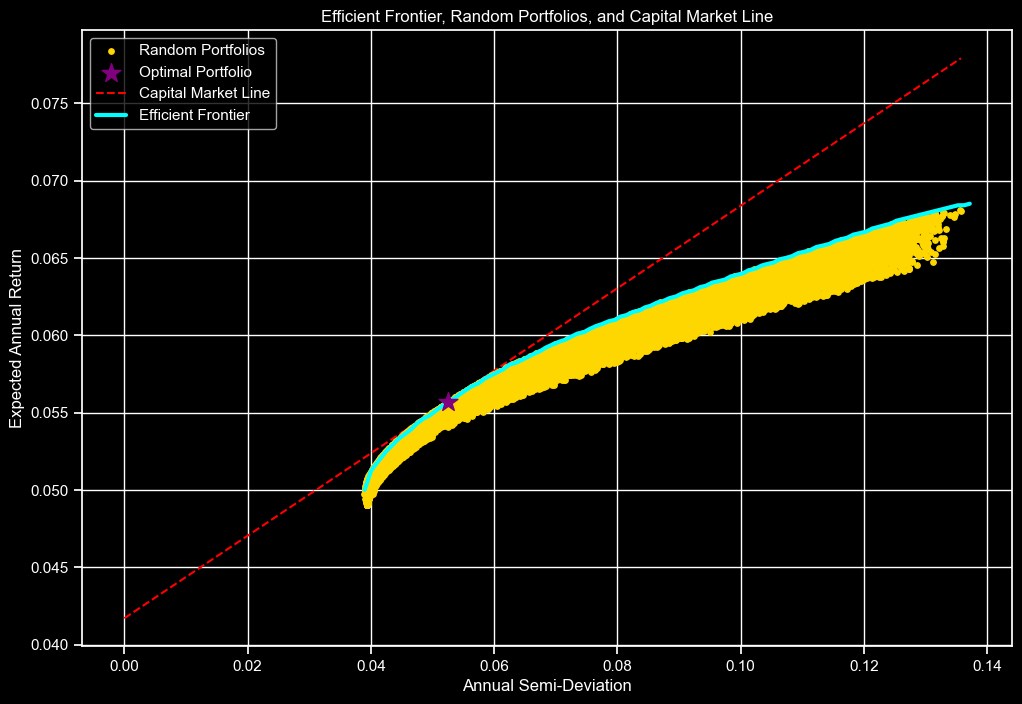

In [44]:
# Plotting
with plt.style.context('dark_background'):
    plt.figure(figsize=(12, 8))

    # Plot random portfolios
    plt.scatter(performance_df_mc['Annual semi-deviation'], performance_df_mc['Expected annual return'], c='gold', label='Random Portfolios', zorder=2, s=15)

    # Plot Optimal Portfolio
    plt.scatter(optimal_portfolio['Annual semi-deviation'], optimal_portfolio['Expected annual return'], c='purple', marker='*', label='Optimal Portfolio', zorder=4, s=200)

    # Plot Capital Market Line
    x_range = np.linspace(0, max(performance_df_mc['Annual semi-deviation']), 100)
    y_cml = risk_free_rate + ((optimal_portfolio['Expected annual return'] - risk_free_rate) / optimal_portfolio['Annual semi-deviation']) * x_range
    plt.plot(x_range, y_cml, color='red', linestyle='--', label='Capital Market Line', zorder=1)

    # Plot Efficient Frontier
    plt.plot(performance_df_optimal.loc['Annual semi-deviation'], performance_df_optimal.loc['Expected annual return'], c='cyan', label='Efficient Frontier', zorder=3, linewidth=3)

    plt.xlabel('Annual Semi-Deviation')
    plt.ylabel('Expected Annual Return')
    plt.title('Efficient Frontier, Random Portfolios, and Capital Market Line')
    plt.legend()
    plt.grid()
    plt.show();

The visualization offers a compelling contrast between the Efficient Frontier and the scatter plot of random portfolios. This enables us to identify the optimal portfolio more robustly and to better understand the risk-return trade-offs inherent in the investment landscape.

## Portfolio Backtests

After determining the optimal portfolio, the next logical step is to test its performance against historical data. Portfolio backtesting is an essential tool for validating a trading strategy, understanding its risks, and estimating its future potential.

### Key Components

1. **Optimal Strategy Function**: The `optimal_strategy` function backtests the portfolio with the optimal weights determined by Efficient Frontier or Monte Carlo Simulation.

2. **Benchmark Strategy Function**: The `benchmark_strategy` function backtests a benchmark portfolio, such as a market index or a 60/40 stock-bond portfolio, for comparison purposes.

3. **Random Strategy**: The `random_strategy` function runs backtests on portfolios with randomly selected securities and weights. This can serve as another benchmark.

4. **WeighRandomlyWithBounds Class**: This custom bt.Algo class generates random portfolio weights within specified bounds.

5. **Backtest Execution**: Both the optimal portfolio and benchmark portfolios are backtested using the bt library.

6. **Performance Metrics**: Risk-adjusted performance metrics like Sortino ratio, Sharpe ratio, and others are computed.

7. **Visualization**: Multiple plots are used for better visualization, such as a performance comparison and a histogram of random benchmark statistics.

In [45]:
def optimal_strategy(strategy_name='Optimal Portfolio'):
    target_weights = weights_df_optimal[optimal_portfolio_index].to_dict()
    # target_weights = target_weights_
    portfolio_strategy = bt.Strategy(strategy_name, [
        bt.algos.RunMonthly(),
        bt.algos.WeighSpecified(**target_weights),
        bt.algos.Rebalance()
        ])
    return bt.Backtest(
        portfolio_strategy,
        historical_prices,
        strategy_name
    )

# Get the Backtest object for the main strategy
strategy_backtest = optimal_strategy()

In [46]:
def benchmark_strategy(strategy_name):
    target_weights = benchmark_portfolio
    portfolio_strategy = bt.Strategy(strategy_name, [
        bt.algos.RunMonthly(),
        bt.algos.WeighSpecified(**target_weights),
        bt.algos.Rebalance()
        ])
    return bt.Backtest(
        portfolio_strategy,
        benchmark_prices,
        strategy_name
    )

# Get the Backtest object for the main strategy
benchmark_backtest = benchmark_strategy(benchmark_name)

In [47]:
# Random benchmark strategy
random_strategy = bt.Strategy('Random Strategy',
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectRandomly(),
                       bt.algos.WeighRandomly(),
                       bt.algos.Rebalance()])

In [48]:
class WeighRandomlyWithBounds(bt.Algo):
    def __init__(self, weight_bounds, *args, **kwargs):
        self.weight_bounds = weight_bounds
        super(WeighRandomlyWithBounds, self).__init__(*args, **kwargs)
    
    def generate_random_weights(self, selected):
        n = len(selected)
        
        weight_bounds_selected = self.weight_bounds[:n]
        lower_bounds, upper_bounds = zip(*weight_bounds_selected)
        
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)

        weights = np.zeros(n)
        remaining = 1.0

        for i in range(n - 1):
            low = max(lower_bounds[i], 0)
            high = min(upper_bounds[i], remaining - np.sum(lower_bounds[i + 1:]))

            if high > low:
                w = np.random.uniform(low, high)
            else:
                w = low

            weights[i] = w
            remaining -= w

        weights[-1] = remaining

        return pd.Series(weights, index=selected)
        
    def __call__(self, target):
        selected = target.temp['selected']
        if len(selected) == 0:
            target.temp['weights'] = pd.Series(dtype=float)
        else:
            weights = self.generate_random_weights(selected)
            target.temp['weights'] = weights
        return True


# Replace the WeighRandomly algo with the new custom one.
random_strategy = bt.Strategy('Random Strategy with Bounds',
                              [bt.algos.RunMonthly(),
                               bt.algos.SelectRandomly(),
                               WeighRandomlyWithBounds(weight_bounds),
                               bt.algos.Rebalance()])

In [49]:
# Backtest with benchmark strategy
results_with_benchmark_strategy = bt.run(strategy_backtest, benchmark_backtest)
results_with_benchmark_strategy.set_riskfree_rate(average_risk_free_rate)

In [50]:
# Backtest with random benchmark strategy
results_with_random_benchmarks = bt.backtest.benchmark_random(strategy_backtest, random_strategy, nsim=1000)
results_with_random_benchmarks.set_riskfree_rate(average_risk_free_rate)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.62it/s]


## Display Backtest Results

In [51]:
results_with_benchmark_strategy.display()

Stat                 Optimal Portfolio    Market Cap Weighted Portfolio
-------------------  -------------------  -------------------------------
Start                2015-05-10           2015-05-10
End                  2023-09-01           2023-09-01
Risk-free rate       2.21%                2.21%

Total Return         78.88%               86.99%
Daily Sharpe         0.68                 0.56
Daily Sortino        1.05                 0.85
CAGR                 7.25%                7.82%
Max Drawdown         -20.75%              -20.14%
Calmar Ratio         0.35                 0.39

MTD                  -0.34%               -0.08%
3m                   1.32%                3.33%
6m                   6.44%                9.26%
YTD                  8.83%                11.43%
1Y                   6.19%                9.48%
3Y (ann.)            0.27%                4.02%
5Y (ann.)            5.32%                7.59%
10Y (ann.)           -                    -
Since Incep. (ann.)  7.25%  

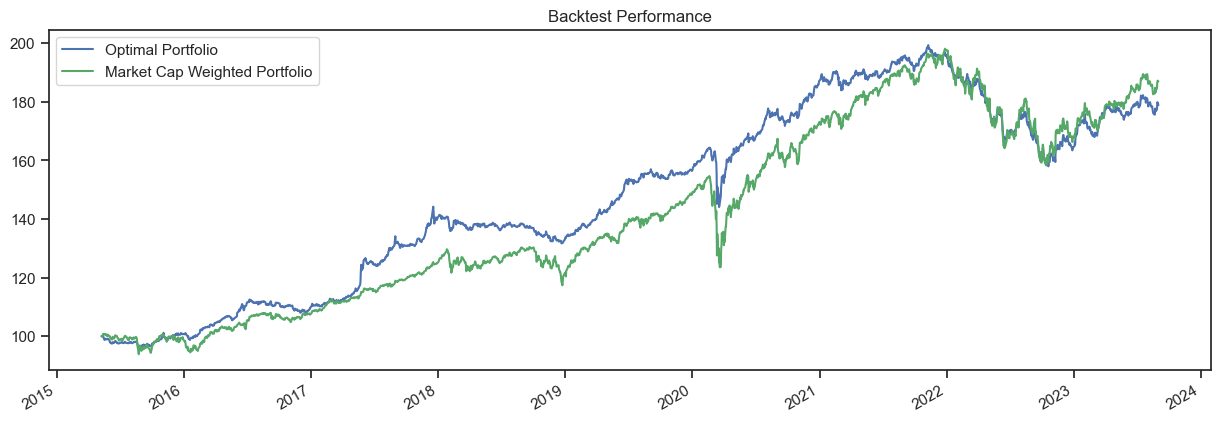

In [52]:
results_with_benchmark_strategy.plot(title='Backtest Performance');

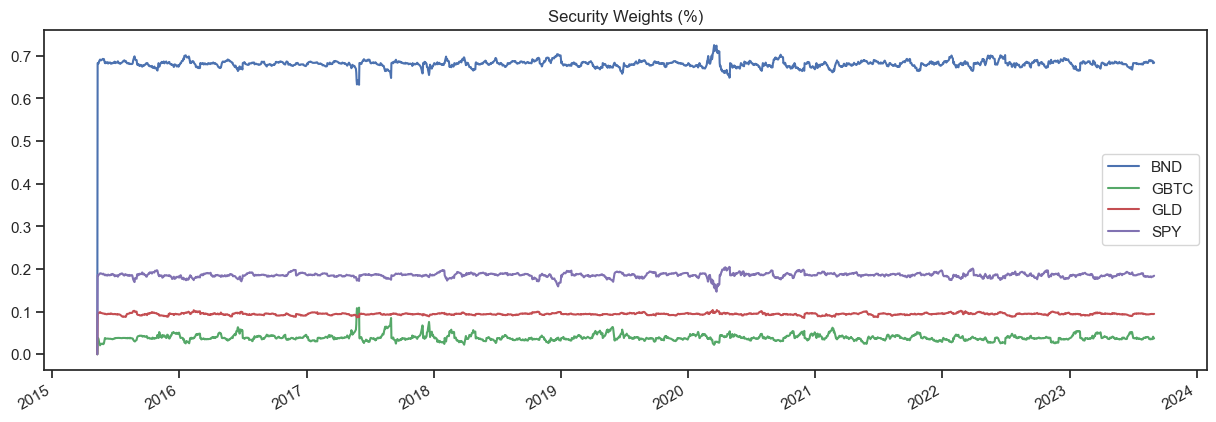

In [53]:
results_with_random_benchmarks.plot_security_weights(title='Security Weights (%)')

### Hypothesis Test

The hypothesis test aims to provide statistical evidence on whether the optimal portfolio's performance is statistically significant compared to a series of random portfolios. A normalized histogram of Sortino Ratios offers a powerful way to conduct this test.

### Key Components

1) **Normalized Histogram**: The plot_normalized_histogram function generates a histogram of normalized Sortino Ratios from the random portfolios, allowing for a direct statistical comparison with the optimal portfolio.

2) **Statistical Significance**: The red line in the histogram represents the Z-Score of the optimal portfolio. Annotations on the plot indicate whether the portfolio's performance is statistically significant.

3) **Hypothesis Explanation**: Based on the Z-Score and the alpha value, the function provides an explanatory text box indicating whether we can reject the null hypothesis, i.e., whether the portfolio significantly outperforms random portfolios.

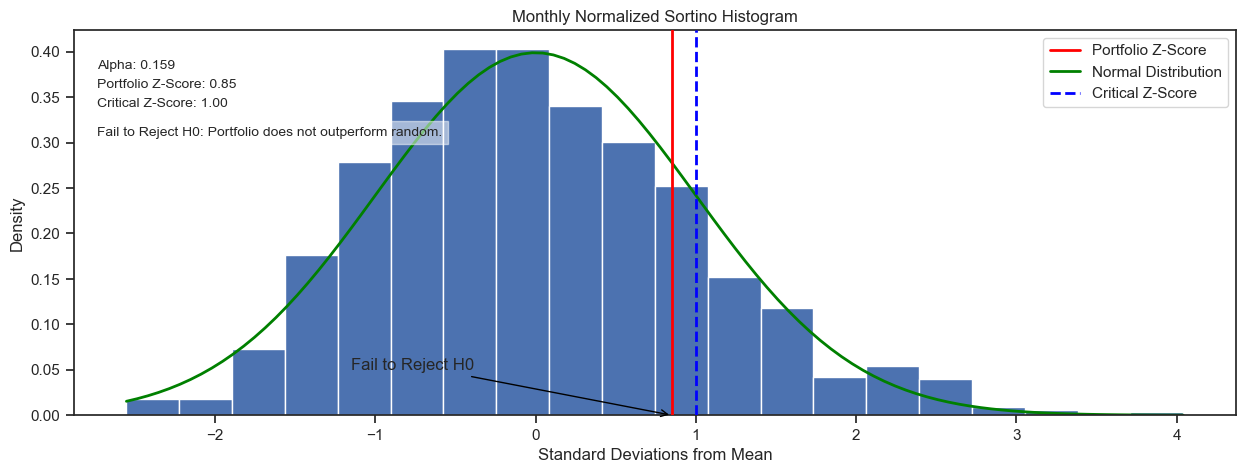

In [54]:
results_with_random_benchmarks.plot_normalized_histogram(statistic="monthly_sortino", alpha=0.159)

### Interpretation

1) **Z-Score**: If the Z-Score (red line) is beyond the critical Z-Score (dashed blue line), it suggests that the portfolio's performance is statistically significant at the chosen alpha level.

2) **Statistical Conclusion**: The explanatory text box offers a straightforward interpretation of the hypothesis test, either confirming or refuting the portfolio's outperformance compared to random benchmarks.

## Key Takeaways

1) **Optimal Portfolio Identification**: Through mathematical optimization techniques, we derived the optimal portfolio, which offers the best risk-reward tradeoff, and showcased its prospective allocations.

2) **Backtesting Performance**: The backtests of the optimal portfolio demonstrated strong historical performance when pitted against the benchmark portfolio, providing a layer of empirical validity to the selected strategy.

3) **Security Weights**: A closer examination of the portfolio's constituent assets over time gave us insights into the diversification and risk management inherent to the portfolio strategy.

4) **Statistical Validation**: The hypothesis test using a normalized histogram of Sortino Ratios solidified our confidence in the strategy. The Z-Score and alpha value used in the test lend statistical weight to the strategy's performance, allowing us to discern whether the portfolio's returns are significantly better than what could be achieved by random chance.

## Risks to this Analysis

In the pursuit of optimal portfolio construction and management, it's crucial to address various layers of risk and uncertainty. While we aim for maximum precision and accuracy, the nature of financial markets, as well as the mathematical models employed, come with inherent limitations and vulnerabilities.

### Investment Risks

1) **Market Risk**: While our models account for historical trends and relationships, they cannot predict unexpected market events like recessions, wars, or pandemics. Such events can adversely affect all asset classes.

2) **Credit Risk**: Bonds and other fixed-income securities are subject to the risk of issuer default. Even corporate equities can be impacted if the issuing company faces solvency issues.

3) **Liquidity Risk**: Some assets in the portfolio might be less liquid, making it difficult to quickly sell them at market value.

4) **Tax Risk**: Changes in tax laws can impact the after-tax returns of your portfolio.

### Model Risks

1) **Overfitting**: The risk that our models, which are trained on past data, fit the training set's "noise" rather than the "signal," affecting their generalizability to new, unseen data.

2) **Assumption Risk**: All financial models are based on assumptions that might not hold true in real-life scenarios (e.g., constant volatility, normally-distributed returns, etc.).

3) **Parameter Sensitivity**: Small changes in the model parameters could lead to significant changes in the portfolio allocations and thus performance.

### Statistical Uncertainty

1) **Sampling Error**: Our historical data is a sample and may not perfectly represent future or unobserved periods.

2) **Confidence Intervals**: While we express our results with metrics like Z-Scores and p-values, these are subject to the level of confidence we choose (e.g., 95% or 99%). A result that is statistically significant at one level may not be at another.

3) **Distribution Assumptions**: The use of metrics like Sharpe or Sortino ratios assumes that the underlying portfolio returns follow specific types of distributions, which may not always be the case.

### Mitigation Strategies

1) **Dynamic Adaptation**: Regularly update and adapt models to incorporate the most recent data and market insights.

2) **Sensitivity Analysis**: Perform sensitivity tests to see how different parameters could impact portfolio performance.

3) **Diversification**: Incorporate a broad range of assets and investment strategies to mitigate systemic and unsystemic risks.

4) **External Validation**: Utilize third-party risk assessment tools and consult external experts for an unbiased assessment of the portfolio's risk profile.